> Welcome to the notebook! This is my submission notebook file for the [Fellowship.ai](https://www.fellowship.ai/) Cohort 34, NLP challenge.

First, let's analyze dataset. Link to the dataset: [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/discussion?sort=hotness)

In [1]:
!pip install fastai

In [2]:
#@ Since I'm using Kaggle's notebook itself, I don't need to import kaggle and stuffs.
import pandas as pd 

ds = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [3]:
ds.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
ds['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

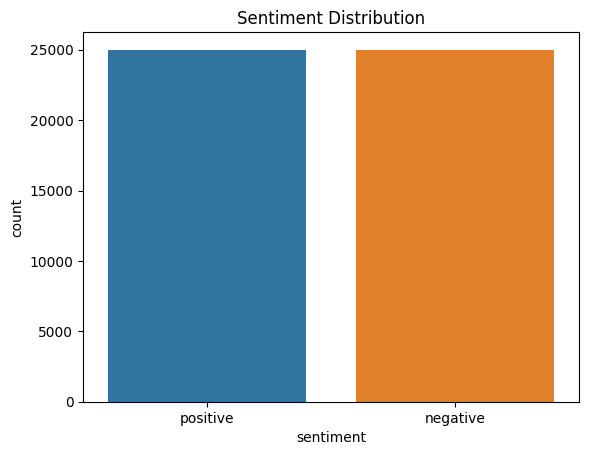

In [6]:
#@ Visualizing: 

import seaborn as sns
import matplotlib.pyplot as plt 

sns.countplot(data= ds, x="sentiment")
plt.title("Sentiment Distribution")
plt.show()

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from fastai.text.all import *

# Define model and tokenizer
model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Custom tokenizer function
def tokenize(texts):
    # Ensure input is a list of strings
    if isinstance(texts, str):
        texts = [texts]
    elif not isinstance(texts, list) or not all(isinstance(t, str) for t in texts):
        raise ValueError("Input must be a string or a list of strings.")
    
    # Tokenize using Hugging Face tokenizer
    tokens = tokenizer(
        texts,
        truncation=True,
        max_length=512,
        padding="max_length",
        return_tensors="pt"
    )
    return tokens['input_ids']

# Create a DataBlock
d_block = DataBlock(
    blocks=(TextBlock.from_df('review', seq_len=512, tok=tokenize), CategoryBlock),
    get_x=ColReader('review'),
    get_y=ColReader('sentiment'),
    splitter=RandomSplitter(valid_pct=0.2)
)

# Load the dataset
dls = d_block.dataloaders(ds, bs=8)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Process Process-1:
Traceback (most recent call last):
Process Process-2:
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.10/dist-packages/fastcore/parallel.py", line 168, in _f_pg
    for i,b in enumerate(obj(batch)): queue.put((start_idx+i,b))
Process Process-3:
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/fastai/text/core.py", line 140, in __call__
    return (L(o).map(self.post_f) for o in self.tok(maps(*self.rules, batch)))


  File "/usr/local/lib/python3.10/dist-packages/fastcore/parallel.py", line 168, in _f_pg
    for i,b in enumerate(obj(batch)): queue.put((start_idx+i,b))
  File "<ipython-input-7-ab11dd07c6f4>", line 15, in tokenize
    raise ValueError("Input must be a string or a list of strings.")
  File "/usr/local/lib/python3.10/dist-packages/fastai/text/core.py", line 140, in __call__
    return (L(o).map(self.post_f) for o in self.tok(maps(*self.rules, batch)))
Traceback (most recent call last):
  File "<ipython-input-7-ab11dd07c6f4>", line 15, in tokenize
    raise ValueError("Input must be a string or a list of strings.")


ValueError: Input must be a string or a list of strings.
Process Process-4:
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
ValueError: Input must be a string or a list of strings.
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/fastcore/parallel.py", line 168, in _f_pg
    for i,b in enumerate(obj(batch)): queue.put((start_idx+i,b))
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.10/dist-packages/fastai/text/core.py", line 140, in __call__
    return (L(o).map(self.post_f) for o in self.tok(maps(*self.rules, batch)))
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-7-ab11dd07c6f4>", line 15, in tokenize
    raise Va

KeyboardInterrupt: 

In [ ]:
learn = Learner(
    dls,
    model,
    loss_func=CrossEntropyLossFlat(),
    metrics=accuracy,
)

In [ ]:
learn.fine_tune(4)